### 0. Import libraries

In [1]:
# These two commands are needed
# !pip install transformers
# !pip install accelerate

In [2]:
%load_ext autoreload
%autoreload 2

In [111]:
# import libraries
import re
import json
import spacy
import torch
import random
import numpy as np
import transformers
import pandas as pd
from tqdm import tqdm
import seaborn as sns
from functools import reduce
from matplotlib import pyplot as plt

# import local scripts
from data_loader import DatasetLoader
from alignment_metrics import *
from gpt2_model import GPT2Model

# produce repeatable results
np.random.seed(seed=42)
transformers.set_seed(42)

# enable CUDNN deterministic mode
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

nlp = spacy.load("en_core_web_sm")

### 1. Load the data

Below are the names of the datasets used by the authors to check if contrastive explanations identify linguistically appropriate evidence.

In [4]:
anaphor_agreement_datasets = [
    "anaphor_gender_agreement",
    "anaphor_number_agreement",
]

# not sure about the one below

argument_structure_datasets = ["animate_subject_passive"]

determiner_noun_agreement_datasets = [
    "determiner_noun_agreement_1",
    "determiner_noun_agreement_irregular_1",
    "determiner_noun_agreement_with_adjective_1",
    "determiner_noun_agreement_with_adj_irregular_1",
]

npi_licesing_datasets = [
    "npi_present_1",
]

subject_verb_agreement_datasets = [
    "distractor_agreement_relational_noun",
    "irregular_plural_subject_verb_agreement_1",
    "regular_plural_subject_verb_agreement_1",
]

phenomena = [
    #"anaphor agreement",
    "argument structure",
    "determiner noun agreement",
    "npi licensing",
    "subject verb agreement",
]
datasets = [
    #anaphor_agreement_datasets,
    argument_structure_datasets,
    determiner_noun_agreement_datasets,
    npi_licesing_datasets,
    subject_verb_agreement_datasets,
]
phenomenon_index = 1

In [5]:
def get_data(datasets):
    data_loader = DatasetLoader()

    data = (
        pd.concat(
            [
                pd.DataFrame(data_loader.load_data(dataset_name)["train"])[
                    ["sentence_good", "sentence_bad"]
                ]
                for dataset_name in datasets
            ]
        )
        .reset_index()
        .drop("index", axis=1)
    )

    return data

In [6]:
data = get_data(datasets[phenomenon_index])
data

,sentence_good,sentence_bad
0,Raymond is selling this sketch.,Raymond is selling this sketches.
1,Craig explored that grocery store.,Craig explored that grocery stores.
2,Eva has scared these children.,Eva has scared these child.
3,Marcus would conceal that pamphlet.,Marcus would conceal that pamphlets.
4,Carmen hadn't shocked these customers.,Carmen hadn't shocked these customer.
...,...,...
3995,Sherry wasn't insulting these excited women.,Sherry wasn't insulting these excited woman.
3996,Sonia will dislike this lucky woman.,Sonia will dislike this lucky women.
3997,Those art galleries irritate this clever woman.,Those art galleries irritate this clever women.
3998,Amy won't work with this unconvinced man.,Amy won't work with this unconvinced men.


### 2. Prepare argument structure data

In [7]:
def get_main_verb(sentence):
    # for argument structure
    doc = nlp(sentence)
    main_verbs = []

    for token in doc:
        if token.pos_ == "VERB":
            main_verbs.append(token.text)

    assert len(main_verbs) == 1

    return main_verbs[0]

### 3. Prepare determiner-noun agreement data

In [8]:
def extract_determiner_from_target_noun(text, target_noun):
    # for determiner-noun agreement

    text += " " + target_noun
    doc = nlp(text)

    for token in doc:
        if token.text.lower() == target_noun.lower() and token.pos_ == "NOUN":
            for child in token.children:
                if child.dep_ == "det":
                    return child.text
    return ""


### 4. Prepare NPI licensing data

In [9]:
def extract_even(text):
    # for npi licensing
    # even is the first word of all the examples in our dataset

    return text.split(" ")[0]

### 5. Prepare subject-verb agreement data

In [10]:
def get_verb_from_sentence(text):
    # for subject-verb agreement

    doc = nlp(text)
    for token in doc:
        if token.text.lower() and (token.pos_ == "VERB" or token.pos_ == "AUX"):
            return token.text

    return ""

In [11]:
def extract_subject_from_target_verb(text, correct_word):
    text += " " + correct_word
    target_verb = get_verb_from_sentence(text)

    if target_verb == "":
        return target_verb
    doc = nlp(text)
    for token in doc:
        if token.text.lower() == target_verb.lower() and (
            token.pos_ == "VERB" or token.pos_ == "AUX"
        ):
            for child in token.children:
                if child.dep_ in {"nsubj", "nsubjpass"}:
                    return child.text
    return ""


In [12]:
def tokenize_sentences(good_sentence, bad_sentence):
    # remove characters that are not letters or apostrophes and replace contractions
    good_sentence_cleaned = re.sub(r"[^\w\s']", "", good_sentence).replace("n't", " not")
    bad_sentence_cleaned = re.sub(r"[^\w\s']", "", bad_sentence).replace("n't", " not")

    # tokenize the text
    good_sentence_tokenized = good_sentence_cleaned.split(" ")
    bad_sentence_tokenized = bad_sentence_cleaned.split(" ")

    return good_sentence_tokenized, bad_sentence_tokenized

In [13]:
def get_common_sentence(good_sentence_tokenized, bad_sentence_tokenized):
    # consider only pairs of sentences with the same number of words
    number_considered_words = min(len(good_sentence_tokenized), len(bad_sentence_tokenized))
    different_lengths = len(good_sentence_tokenized) != len(bad_sentence_tokenized)

    good_sentence_tokenized = good_sentence_tokenized[:number_considered_words]
    bad_sentence_tokenized = bad_sentence_tokenized[:number_considered_words]

    # get the common part of the two sentences (until the first different word)
    same_tokens = np.array(good_sentence_tokenized) == np.array(bad_sentence_tokenized)
    index_first_diff_token = np.where(same_tokens == False)[0][0]

    common_sentence_tokenized = good_sentence_tokenized[:index_first_diff_token]
    common_sentence = " ".join(common_sentence_tokenized)

    return (
        common_sentence,
        common_sentence_tokenized,
        index_first_diff_token,
        different_lengths,
    )


In [14]:
def get_target(phenomenon_type, sentence, correct_word):
    if phenomenon_type == "argument structure":
        return get_main_verb(sentence)
    elif phenomenon_type == "determiner noun agreement":
        return extract_determiner_from_target_noun(sentence, correct_word)
    elif phenomenon_type == "npi licensing":
        return extract_even(sentence)
    elif phenomenon_type == "subject verb agreement":
        return extract_subject_from_target_verb(sentence, correct_word)

In [15]:
def preprocess_data(input_data, phenomenon_type):
    good_bad_sentences = input_data.to_numpy()
    extracted_sentences_data = []
    dif_lengths_counter = 0

    for good_sentence, bad_sentence in tqdm(good_bad_sentences):
        good_sentence_tokenized, bad_sentence_tokenized = tokenize_sentences(good_sentence, bad_sentence)
        sentence_info = get_common_sentence(good_sentence_tokenized, bad_sentence_tokenized)
        common_sentence, common_sentence_tokenized, index_first_diff_token, different_lengths = sentence_info

        if different_lengths:
            dif_lengths_counter += 1

        # get the correct and foil words
        correct_word = good_sentence_tokenized[index_first_diff_token]
        foil_word = bad_sentence_tokenized[index_first_diff_token]

        # get the target token
        target = get_target(phenomenon_type, common_sentence, correct_word)

        if target == "":
            continue

        if len(good_sentence_tokenized) -1 == index_first_diff_token:
            is_full_sentence = True
        else:
            is_full_sentence = False

        # construct an array where 1s represent the position of the target word
        known_evidence = np.zeros(len(common_sentence_tokenized))
        evidence_index = np.where(np.array(common_sentence_tokenized) == target)[0][0]
        known_evidence[evidence_index] = 1

        extracted_data = [known_evidence, common_sentence, correct_word, foil_word, is_full_sentence]
        extracted_sentences_data.append(extracted_data)

    print(f"The number of pairs with different number of words: {dif_lengths_counter}")
    print(f"Number of processed senteces: {len(extracted_sentences_data)}/{len(good_bad_sentences)}")

    return extracted_sentences_data

In [16]:
extracted_sentences_data = preprocess_data(data, phenomena[phenomenon_index])

100%|██████████| 4000/4000 [00:18<00:00, 212.05it/s]

The number of pairs with different number of words: 0
Number of processed senteces: 3823/4000


In [17]:
gpt2model = GPT2Model()

In [18]:
def match_evidence_with_tokenization(space_tokenization, gpt_tokenization, known_evidence):
    # this function adds 0s or 1s in the known evidence to match the list of GPT tokens

    space_tokenization_index = 0
    updated_known_evidence = []
    accumulated_string = gpt_tokenization[0]

    for gpt_tokenization_index, gpt_token in enumerate(gpt_tokenization[1:]):
        if accumulated_string == space_tokenization[space_tokenization_index]:
            updated_known_evidence.append(known_evidence[space_tokenization_index])
            accumulated_string = gpt_tokenization[gpt_tokenization_index + 1]
            space_tokenization_index += 1

        else:
            accumulated_string += gpt_token
            updated_known_evidence.append(known_evidence[space_tokenization_index])

    updated_known_evidence.append(known_evidence[space_tokenization_index])

    return updated_known_evidence

In [19]:
import math

In [20]:
def compute_alignment_metrics(sentence_data, contrastive_method):
    known_evidence = sentence_data[0]
    sentence = sentence_data[1]
    correct_word = sentence_data[2]
    foil_word = sentence_data[3]

    saliency_map = contrastive_method(sentence, correct_word, foil_word)
    extracted_words = [explanation[0].strip() for explanation in saliency_map]
    explanation = [explanation[1] for explanation in saliency_map]

    if sentence.split(" ") == extracted_words or math.isnan(saliency_map[0][1]):
        return None

    known_evidence = match_evidence_with_tokenization(sentence.split(" "), extracted_words, known_evidence)
    mean_dot_product = compute_mean_dot_product([explanation], [known_evidence])
    mean_probes_needed = compute_mean_probes_needed([explanation], [known_evidence])
    mean_reciprocal_rank = compute_mean_reciprocal_rank([explanation], [known_evidence])

    return saliency_map

In [21]:
def get_contrastive_method(index):
    if index == 0:
        return "gradient norm", gpt2model.get_contrastive_gradient_norm
    elif index == 1:
        return "input x gradient", gpt2model.get_contrastive_input_x_gradient
    else:
        return "input erasure", gpt2model.get_input_erasure

In [22]:
def extract_form_data(extracted_sentences_data, phenomenon, number_of_examples=8):
    index = 0
    form_data = []
    random.shuffle(extracted_sentences_data)

    for sentence_data in extracted_sentences_data:
        contrastive_function_name, contrastive_function = get_contrastive_method(index)
        saliency_map = compute_alignment_metrics(sentence_data, contrastive_function)

        if contrastive_function_name is None or saliency_map is None:
            continue

        form_data.append(
            {
                "phenomenon": phenomenon,
                "input sentence": sentence_data[1],
                "correct word": sentence_data[2],
                "wrong word": sentence_data[3],
                "contrastive function": contrastive_function_name,
                "explanation": saliency_map,
            }
        )

        index += 1

        if index == number_of_examples:
            break

    return form_data

## Extract data for form

In [23]:
global_form_data = []

for phenomenon, datasets_for_phenomenon in zip(phenomena, datasets):
    data = get_data(datasets_for_phenomenon)
    extracted_sentences_data = preprocess_data(data, phenomenon)
    global_form_data += extract_form_data(extracted_sentences_data, phenomenon)

with open('./data/form_data.json', 'w') as f:
    json.dump(global_form_data, f)

100%|██████████| 1000/1000 [00:04<00:00, 213.80it/s]
/home/jovyan/XAI/project/gpt2_model.py:82: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  gradient_norm = torch.norm(torch.tensor(gradients[i]), p=1)


The number of pairs with different number of words: 12
Number of processed senteces: 1000/1000


100%|██████████| 4000/4000 [00:18<00:00, 215.62it/s]
/home/jovyan/XAI/project/gpt2_model.py:82: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  gradient_norm = torch.norm(torch.tensor(gradients[i]), p=1)
/home/jovyan/XAI/project/gpt2_model.py:139: RuntimeWarning: invalid value encountered in divide
  normalized_probabilities = numpy_outputs/sum(numpy_outputs)


The number of pairs with different number of words: 0
Number of processed senteces: 3823/4000


100%|██████████| 1000/1000 [00:00<00:00, 54861.93it/s]
/home/jovyan/XAI/project/gpt2_model.py:82: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  gradient_norm = torch.norm(torch.tensor(gradients[i]), p=1)


The number of pairs with different number of words: 0
Number of processed senteces: 1000/1000


100%|██████████| 3000/3000 [00:24<00:00, 124.14it/s]


The number of pairs with different number of words: 0
Number of processed senteces: 2572/3000


/home/jovyan/XAI/project/gpt2_model.py:82: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  gradient_norm = torch.norm(torch.tensor(gradients[i]), p=1)
/home/jovyan/XAI/project/gpt2_model.py:139: RuntimeWarning: invalid value encountered in divide
  normalized_probabilities = numpy_outputs/sum(numpy_outputs)


In [116]:
def plot_explanation(words, scores, name="explanation"):
    fig, ax = plt.subplots(1, 1)
    fig.set_size_inches(1.2 * len(scores), 0.5)

    rounded_scores = [round(score, 4) for score in scores]
    xticks_positions = np.array(range(len(rounded_scores))) + 0.5

    sns.heatmap(data=np.array([scores]), annot=labels, fmt="", cmap='coolwarm', cbar=False, ax=ax)
    ax.set_xticks(ticks=xticks_positions, labels=np.array(rounded_scores))
    ax.set_yticks([])

    plt.show()
    fig.savefig(f"./visual_explanations/{name}.png") 

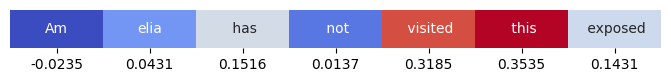

In [117]:
words = [info[0] for info in global_form_data[10]["explanation"]]
# words contains ['Am', 'elia', ' has', ' not', ' visited', ' this', ' exposed']
scores = [info[1] for info in global_form_data[10]["explanation"]]
# scores contains [-0.023513547215242535, 0.04307653600029133, 0.15159219643324162, 0.013719914235362795, 0.3185397058709933, 0.3534767672955558, 0.14310842737979765]

plot_explanation(words, scores)